In [21]:
import torch
from torch import nn
from torch.utils import data as Data
from torchvision import transforms, datasets
from d2l import torch as d2l

In [22]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

In [23]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [24]:
X=torch.rand(size=(1,1,224,224))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


In [35]:
lr,num_epochs,batch_size=0.1,10,128
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.RandomRotation(30),
    transforms.ToTensor()
])
mnist_train = datasets.FashionMNIST(root='dataset/Fashion_Minist', train=True, transform=transform, download=True)
mnist_test = datasets.FashionMNIST(root='dataset/Fashion_Minist', train=False, transform=transform, download=True)
train_iter = Data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = Data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=0)


def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = [0, 0]
    for X, y in data_iter:
        if isinstance(X, list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            metric[0] += torch.sum(torch.argmax(net(X), dim=1) == y).item()
            metric[1] += y.shape[0]
        return metric[0] / metric[1]
def train_cj(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6).

    Defined in :numref:`sec_lenet`"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = [0,0,0]
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric[0] += l * X.shape[0]
                metric[1] += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
                metric[2] += y.shape[0]
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                print('epoch %d, batch %d, loss %.4f, train acc %.3f' % (epoch + 1, i + 1, train_l, train_acc))
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                print('epoch %d, batch %d, loss %.4f, train acc %.3f' % (epoch + 1, i + 1, train_l, train_acc))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    # def init_weights(m):
    #     if type(m) == nn.Linear or type(m) == nn.Conv2d:
    #         torch.nn.init.xavier_normal_(m.weight)
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    num_batches = len(train_iter)
    for epoch in range(num_epochs):
        metric = [0, 0, 0]
        train_l, train_acc, n = 0.0, 0.0, 0
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric[0] += l * X.shape[0]
                metric[1] += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
                metric[2] += y.shape[0]
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                print('epoch %d, batch %d, loss %.4f, train acc %.3f' % (epoch + 1, i + 1, train_l, train_acc))
    test_acc = evaluate_accuracy_gpu(net, test_iter)
    print(f'loss {train_l:.3f},train acc {train_acc:.3f},test acc {test_acc:.3f}')

In [36]:
train_ch6(net,train_iter,test_iter,num_epochs,lr,'cuda')

training on cuda
epoch 1, batch 93, loss 2.3156, train acc 0.105
epoch 1, batch 186, loss 2.2897, train acc 0.110
epoch 1, batch 279, loss 2.2622, train acc 0.129
epoch 1, batch 372, loss 2.2233, train acc 0.151
epoch 1, batch 465, loss 2.1766, train acc 0.176
epoch 1, batch 469, loss 2.1761, train acc 0.177


KeyboardInterrupt: 

loss 0.342, train acc 0.875, test acc 0.847
1530.1 examples/sec on cuda:0


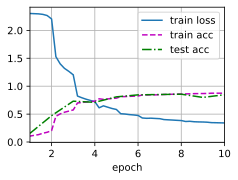

In [26]:
lr, num_epochs, batch_size = 0.1, 10, 128
# train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())